In [2]:
import pandas as pd

columns = [
    "Cable_ID","Voltage_Level","Feeder_ID","Sub_Feeder_ID","From_Switch","To_Switch",
    "Cable_Type","Cable_Age_Years","Length_m","Installation_Environment",
    "Soil_Type","Humidity","Proximity_to_Water","Load_History_Avg_Load","Load_History_Peak_Load", 
    "Loading_Cycles","Overload_Events","IR_Measurement_MOhm","Tan_Delta","Partial_Discharge_Frequency",
    "Partial_Discharge_Intensity","Thermal_History_Excursions","Num_Faults","Fault_Type","Repairs_Count",
    "Joint_History","Corrosivity","Water_Ingress","Remarks"
]

# Sample data for different voltage levels. You can add or import your actual data here.
data = [
    [
        "33KV-SW1-SW2", "33kV", "", "", "SW1", "SW2", "XLPE", 7, 1200, "Underground",
        "Sandy", "Medium", "Far", 60, 100, 150, 1, 500, 0.001, 0, 0, 0, 0, "None", 0, "Original", "Low", "No", "Healthy"
    ],
    [
        "22KV-SW3-SW4", "22kV", "", "", "SW3", "SW4", "PILC", 3, 800, "Overhead",
        "Clay", "High", "Near", 50, 90, 100, 0, 400, 0.002, 0, 0, 1, 1, "Earth Fault", 1, "Repaired once", "Medium", "No", "Monitor"
    ],
    [
        "FDR1-DT001", "11kV", "FDR1", "", "", "", "XLPE", 8, 400, "Underground",
        "Loam", "Medium", "Near", 40, 80, 120, 2, 120, 0.003, 1, 3, 1, 2, "Earth Fault", 2, "Multiple joints", "High", "Yes", "Healthy"
    ],
    [
        "FDR2-SUB1-DT005", "11kV", "FDR2", "SUB1", "", "", "XLPE", 4, 220, "Underground",
        "Rocky", "Low", "Far", 30, 50, 90, 0, 200, 0.001, 0, 0, 0, 0, "None", 0, "Original", "Low", "No", ""
    ],
]

df = pd.DataFrame(data, columns=columns)

# Save as Excel and CSV for use
# df.to_excel("/media/sagarkumar/New Volume/SAGAR/DATA_GENERATION/master_cable_data_final.xlsx", index=False)
df.to_csv("/media/sagark24/New Volume/MERGE CDIS/DATA_GENERATION/master_cable_data_final.csv", index=False)

print(df)


          Cable_ID Voltage_Level Feeder_ID Sub_Feeder_ID From_Switch  \
0     33KV-SW1-SW2          33kV                                 SW1   
1     22KV-SW3-SW4          22kV                                 SW3   
2       FDR1-DT001          11kV      FDR1                             
3  FDR2-SUB1-DT005          11kV      FDR2          SUB1               

  To_Switch Cable_Type  Cable_Age_Years  Length_m Installation_Environment  \
0       SW2       XLPE                7      1200              Underground   
1       SW4       PILC                3       800                 Overhead   
2                 XLPE                8       400              Underground   
3                 XLPE                4       220              Underground   

   ... Partial_Discharge_Frequency Partial_Discharge_Intensity  \
0  ...                           0                           0   
1  ...                           0                           0   
2  ...                           1                

In [21]:
import pandas as pd
import re

# 1. Load file (final clean file)
df_original = pd.read_csv('/media/sagark24/New Volume/MERGE CDIS/DATA_GENERATION/TXN_NMS_HTLOGSHEET_cleaned.csv', low_memory=False)

# 2. Filter ENTRY_TYPE == 1
df_entry1 = df_original[df_original['ENTRY_TYPE'] == 1].copy().reset_index(drop=True)

# 3. UPPERCASE remarks
df_entry1['FREE_REMARKS_UPPER'] = df_entry1['FREE_REMARKS'].astype(str).str.upper()

# 4. Extraction functions
def extract_size(text):
    m = re.search(r'X\s*([\d\.\+\-\s]*SQ\.?\s*MM)', text)
    return m.group(1).replace(" ", "") if m else ""

def extract_insulation(text):
    m = re.search(r'(PILC\+XLPE|XLPE\+PILC|PILC|XLPE)', text)
    return m.group(1) if m else ""

def extract_voltage(text):
    m = re.search(r'(\d{2,3})\s*KV', text)
    return f"{m.group(1)}KV" if m else ""

def extract_type(text):
    m = re.search(r'(HTCF SECTION|LT SECTION|HT SECTION)', text)
    return m.group(1) if m else ""

def extract_section(text):
    m = re.search(r'BETWEEN\s+(.+?)\s+S/S\s+SWITCH:([0-9]+)\s+TO\s+(.+?)\s+S/S\s+SWITCH:([0-9]+)', text)
    if m:
        return pd.Series([m.group(1).strip(), m.group(2), m.group(3).strip(), m.group(4)])
    return pd.Series(["", "", "", ""])

def extract_delayed_reason(text):
    m = re.search(r'DELAYED DUE TO(.*?)(?:NOTIFICATION NO|$)', text)
    return m.group(1).strip() if m else ""

def extract_fault_nature(text):
    patterns = [
        'CABLE DAMAGED BY', 'DMS OFFLINE AT', 'FPI MALFUNCTION',
        'FAILED TO OPEN', 'FAILED TO CLOSE', 'WENT OFFLINE',
        'FEEDER TRIPPING', 'TRAFFIC ON', 'SUPPLY RESTORATION DELAYED'
    ]
    found = []
    for pat in patterns:
        for m in re.finditer(r'({0}.*?)(?:\.|,|;|NOTIFICATION NO|$)'.format(re.escape(pat)), text):
            found.append(m.group(1).strip())
    return '; '.join(found) if found else ""

# 5. Extraction (create new DataFrame for output)
out = pd.DataFrame()
out['Size'] = df_entry1['FREE_REMARKS_UPPER'].apply(extract_size)
out['Insulation'] = df_entry1['FREE_REMARKS_UPPER'].apply(extract_insulation)
out['Voltage'] = df_entry1['FREE_REMARKS_UPPER'].apply(extract_voltage)
out['Type'] = df_entry1['FREE_REMARKS_UPPER'].apply(extract_type)

section_cols = df_entry1['FREE_REMARKS_UPPER'].apply(extract_section)
section_cols.columns = ['FROM', 'FROM_SWITCH', 'TO', 'TO_SWITCH']
out = pd.concat([out, section_cols], axis=1)

out['DELAYED_REASON'] = df_entry1['FREE_REMARKS_UPPER'].apply(extract_delayed_reason)
out['FAULT_NATURE'] = df_entry1['FREE_REMARKS_UPPER'].apply(extract_fault_nature)

# Time columns
out['TIME_OUTAGE'] = df_entry1['TIME_OUTAGE'].astype(str)
out['MAIN_REPORTED_TIME'] = pd.to_datetime(df_entry1['MAIN_REPORTED_TIME'], errors='coerce')
out['TIME_RESTORED'] = pd.to_datetime(df_entry1['TIME_RESTORED'], errors='coerce')
out['TIME_DIFFERENCE'] = (out['TIME_RESTORED'] - out['MAIN_REPORTED_TIME']).dt.total_seconds() / 60

# 6. Save
final_cols = [
    'Size', 'Insulation', 'Voltage', 'Type',
    'FROM', 'FROM_SWITCH', 'TO', 'TO_SWITCH',
    'DELAYED_REASON', 'FAULT_NATURE',
    'TIME_OUTAGE', 'MAIN_REPORTED_TIME', 'TIME_RESTORED', 'TIME_DIFFERENCE'
]
out[final_cols].to_csv('/media/sagark24/New Volume/MERGE CDIS/DATA_GENERATION/processed_fault_data_FINAL.csv', index=False)
print("Extracted file written.")
print(out[final_cols].head(10))


Extracted file written.
                        Size Insulation Voltage          Type  \
0                      SQ.MM  PILC+XLPE    11KV  HTCF SECTION   
1            .06+70+120SQ.MM  PILC+XLPE    11KV  HTCF SECTION   
2  0.15+185+225+300+240SQ.MM  PILC+XLPE    11KV  HTCF SECTION   
3                   120SQ.MM       PILC    11KV  HTCF SECTION   
4                   120SQ.MM       PILC    11KV  HTCF SECTION   
5                   120SQ.MM       PILC    11KV  HTCF SECTION   
6                   120SQ.MM       PILC    11KV  HTCF SECTION   
7                   120SQ.MM       PILC    11KV  HTCF SECTION   
8                   120SQ.MM       PILC    11KV  HTCF SECTION   
9                   120SQ.MM       PILC    11KV  HTCF SECTION   

                       FROM FROM_SWITCH                      TO TO_SWITCH  \
0  VISHWESHWAR NAGAR HETALI       40478                  SAMANT     05587   
1        JAWAHAR NAGAR NO.3       13847    SONAVALA ESTATE NO.1     00714   
2                            

CHECK THE DATA 

In [18]:
import csv

file_path = '/media/sagark24/New Volume/MERGE CDIS/DATA_GENERATION/TXN_NMS_HTLOGSHEET_cleaned.csv'
linebreak_count = 0
ctrl_count = 0

with open(file_path, 'r', encoding='utf-8', errors='replace') as f:
    reader = csv.reader(f)
    for i, row in enumerate(reader):
        for j, cell in enumerate(row):
            if '\n' in cell or '\r' in cell:
                print(f'Linebreak found in row {i+1}, column {j+1}: {repr(cell)}')
                linebreak_count += 1
            # Any ASCII control char except tab (9) and newline (10, 13)
            if any(ord(c) < 32 and ord(c) not in (9, 10, 13) for c in cell):
                print(f'Ctrl char found in row {i+1}, column {j+1}: {repr(cell)}')
                ctrl_count += 1
      

print(f'Total linebreak cells found: {linebreak_count}')
print(f'Total control-char cells found: {ctrl_count}')


Total linebreak cells found: 0
Total control-char cells found: 0


In [19]:
with open(file_path, 'r', encoding='utf-8') as f:
    expected = None
    for i, line in enumerate(f):
        cols = line.count(',') + 1
        if i == 0:
            expected = cols
        elif cols != expected:
            print(f"Row {i+1} has {cols} columns (Expected: {expected})")
      

In [20]:
import pandas as pd
import re

# Raw file read, no parse (just lines)
filename = "/media/sagark24/New Volume/MERGE CDIS/DATA_GENERATION/TXN_NMS_HTLOGSHEET_cleaned.csv"
with open(filename, encoding='utf-8', errors='ignore') as f:
    lines = f.readlines()

print("Total lines:", len(lines))

# Line breaks within a field detection (very likely in 'FREE_REMARKS' column)
for i, line in enumerate(lines):
    if '\n' in line or '\r' in line:
        # \n to har line me hoga, but internal bhi ho sakta hai
        if line.count('\n') > 1 or line.count('\r') > 1:
            print(f"Line {i+1}: Multiple linebreaks in a single line")

    # Look for possible tabs, weird ascii
    if re.search(r"[\t\x0b\x0c\x1b]", line):
        print(f"Line {i+1}: Contains tab or control char")

# Check for unclosed quotes
for i, line in enumerate(lines):
    if line.count('"') % 2 != 0:
        print(f"Line {i+1}: Unmatched double quote")

# Column count (by comma)
col_counts = [l.count(',') for l in lines]
mode_col_count = max(set(col_counts), key=col_counts.count)
for idx, c in enumerate(col_counts):
    if c != mode_col_count:
        print(f"Line {idx+1}: {c} columns (Expected: {mode_col_count})")


Total lines: 23705


CLEANED DATA

In [17]:
import re

# === CONFIGURATION ===
filename = "/media/sagark24/New Volume/MERGE CDIS/2-Year-data/TXN_NMS_HTLOGSHEET.csv"
cleaned_filename = "/media/sagark24/New Volume/MERGE CDIS/DATA_GENERATION/TXN_NMS_HTLOGSHEET_cleaned.csv"
deleted_filename = "/media/sagark24/New Volume/MERGE CDIS/DATA_GENERATION/TXN_NMS_HTLOGSHEET_deleted.csv"

# === READ ALL LINES ===
with open(filename, encoding='utf-8', errors='ignore') as f:
    lines = f.readlines()

# === HEADER AND COLUMN COUNT ===
header = lines[0]
expected_col_count = header.count(',')

def check_line_issues(line, expected_col_count):
    issues = []
    # Remove newline for checks
    line_no_nl = line.replace('\r', '').replace('\n', '')
    # Tab or control characters
    if re.search(r"[\t\x0b\x0c\x1b]", line_no_nl):
        issues.append("Tab/control char")
    # Unmatched quotes
    if line_no_nl.count('"') % 2 != 0:
        issues.append("Unmatched double quote")
    # Wrong column count
    col_count = line_no_nl.count(',')
    if col_count != expected_col_count:
        issues.append(f"Column count {col_count} (Expected {expected_col_count})")
    # Multiple linebreaks INSIDE line (almost never happens, as we're reading lines)
    if line.count('\n') > 1 or line.count('\r') > 1:
        issues.append("Multiple linebreaks in line")
    return issues

# === FILTER LINES ===
cleaned_lines = [header]
deleted_lines = [header.strip() + ",REASON\n"]  # Add a reason column to deleted

for idx, line in enumerate(lines[1:], start=2):  # 2nd line onwards
    issues = check_line_issues(line, expected_col_count)
    if issues:
        reason = "; ".join(issues)
        deleted_lines.append(line.strip() + f',"{reason}"\n')
    else:
        cleaned_lines.append(line)

# === WRITE OUTPUT FILES ===
with open(cleaned_filename, 'w', encoding='utf-8') as f:
    f.writelines(cleaned_lines)

with open(deleted_filename, 'w', encoding='utf-8') as f:
    f.writelines(deleted_lines)

print(f"Cleaned rows: {len(cleaned_lines) - 1}")
print(f"Deleted rows: {len(deleted_lines) - 1}")
print(f"Cleaned file: {cleaned_filename}")
print(f"Deleted file: {deleted_filename}")


Cleaned rows: 23704
Deleted rows: 1433
Cleaned file: /media/sagark24/New Volume/MERGE CDIS/DATA_GENERATION/TXN_NMS_HTLOGSHEET_cleaned.csv
Deleted file: /media/sagark24/New Volume/MERGE CDIS/DATA_GENERATION/TXN_NMS_HTLOGSHEET_deleted.csv


In [25]:
import csv

rawfile = '/media/sagark24/New Volume/MERGE CDIS/2-Year-data/TXN_NMS_HTLOGSHEET.csv'
goodfile = '/media/sagark24/New Volume/MERGE CDIS/DATA_GENERATION/TXN_NMS_HTLOGSHEET_good.csv'
badfile = '/media/sagark24/New Volume/MERGE CDIS/DATA_GENERATION/TXN_NMS_HTLOGSHEET_bad.csv'

with open(rawfile, encoding='utf-8', errors='ignore') as f:
    reader = csv.reader(f)
    header = next(reader)
    ncol = len(header)

with open(rawfile, encoding='utf-8', errors='ignore') as f, \
     open(goodfile, 'w', encoding='utf-8', newline='') as fgood, \
     open(badfile, 'w', encoding='utf-8', newline='') as fbad:
    reader = csv.reader(f)
    writer_good = csv.writer(fgood)
    writer_bad = csv.writer(fbad)
    header = next(reader)
    writer_good.writerow(header)
    writer_bad.writerow(header)
    for row in reader:
        if len(row) == ncol:
            writer_good.writerow(row)
        else:
            writer_bad.writerow(row)
print("Done separating good and bad rows.")


Done separating good and bad rows.


ONLY FREE_REMARKS ANALYZE


In [30]:
import pandas as pd
import re

# 1. Load the file
df = pd.read_csv('/media/sagark24/New Volume/MERGE CDIS/DATA_GENERATION/TXN_NMS_HTLOGSHEET_FREE_REMARKS_ONLY.csv', usecols=['FREE_REMARKS'], low_memory=False)

# 2. UPPERCASE remarks for consistency
df['FREE_REMARKS_UPPER'] = df['FREE_REMARKS'].astype(str).str.upper()

# 3. Extraction functions
def extract_size(text):
    m = re.search(r'X\s*([\d\.\+\-\s]*SQ\.?\s*MM)', text)
    return m.group(1).replace(" ", "") if m else ""

def extract_insulation(text):
    m = re.search(r'(PILC\+XLPE|XLPE\+PILC|PILC|XLPE)', text)
    return m.group(1) if m else ""

def extract_voltage(text):
    m = re.search(r'(\d{2,3})\s*KV', text)
    return f"{m.group(1)}KV" if m else ""

def extract_type(text):
    m = re.search(r'(HTCF SECTION|LT SECTION|HT SECTION)', text)
    return m.group(1) if m else ""

def extract_section(text):
    m = re.search(r'BETWEEN\s+(.+?)\s+S/S\s+SWITCH:([0-9]+)\s+TO\s+(.+?)\s+S/S\s+SWITCH:([0-9]+)', text)
    if m:
        return pd.Series([m.group(1).strip(), m.group(2), m.group(3).strip(), m.group(4)])
    return pd.Series(["", "", "", ""])

def extract_delayed_reason(text):
    m = re.search(r'DELAYED DUE TO(.*?)(?:NOTIFICATION NO|$)', text)
    return m.group(1).strip() if m else ""

def extract_fault_nature(text):
    patterns = [
        'CABLE DAMAGED BY', 'DMS OFFLINE AT', 'FPI MALFUNCTION',
        'FAILED TO OPEN', 'FAILED TO CLOSE', 'WENT OFFLINE',
        'FEEDER TRIPPING', 'TRAFFIC ON', 'SUPPLY RESTORATION DELAYED'
    ]
    found = []
    for pat in patterns:
        for m in re.finditer(r'({0}.*?)(?:\.|,|;|NOTIFICATION NO|$)'.format(re.escape(pat)), text):
            found.append(m.group(1).strip())
    return '; '.join(found) if found else ""

# 4. Apply extraction functions
out = pd.DataFrame()
out['Size'] = df['FREE_REMARKS_UPPER'].apply(extract_size)
out['Insulation'] = df['FREE_REMARKS_UPPER'].apply(extract_insulation)
out['Voltage'] = df['FREE_REMARKS_UPPER'].apply(extract_voltage)
out['Type'] = df['FREE_REMARKS_UPPER'].apply(extract_type)

section_cols = df['FREE_REMARKS_UPPER'].apply(extract_section)
section_cols.columns = ['FROM', 'FROM_SWITCH', 'TO', 'TO_SWITCH']
out = pd.concat([out, section_cols], axis=1)

out['DELAYED_REASON'] = df['FREE_REMARKS_UPPER'].apply(extract_delayed_reason)
out['FAULT_NATURE'] = df['FREE_REMARKS_UPPER'].apply(extract_fault_nature)

# 5. Save results
out.to_csv('/media/sagark24/New Volume/MERGE CDIS/DATA_GENERATION/processed_fault_data_ONLY_FREEREMARKS.csv', index=False)
print("Extracted file written.")
print(out.head(10))


Extracted file written.
                        Size Insulation Voltage          Type  \
0                                         220KV                 
1                                                               
2                      SQ.MM  PILC+XLPE    11KV  HTCF SECTION   
3            .06+70+120SQ.MM  PILC+XLPE    11KV  HTCF SECTION   
4  0.15+185+225+300+240SQ.MM  PILC+XLPE    11KV  HTCF SECTION   
5                   120SQ.MM       PILC    11KV  HTCF SECTION   
6                   120SQ.MM       PILC    11KV  HTCF SECTION   
7                   120SQ.MM       PILC    11KV  HTCF SECTION   
8                   120SQ.MM       PILC    11KV  HTCF SECTION   
9                   120SQ.MM       PILC    11KV  HTCF SECTION   

                       FROM FROM_SWITCH                      TO TO_SWITCH  \
0                                                                           
1                                                                           
2  VISHWESHWAR NAGAR HETALI  

In [29]:
import csv

input_file = '/media/sagark24/New Volume/MERGE CDIS/2-Year-data/TXN_NMS_HTLOGSHEET.csv'
output_file = '/media/sagark24/New Volume/MERGE CDIS/DATA_GENERATION/TXN_NMS_HTLOGSHEET_FREE_REMARKS_ONLY.csv'

with open(input_file, encoding='utf-8', errors='ignore') as f, \
     open(output_file, 'w', encoding='utf-8', newline='') as fout:
    reader = csv.reader(f)
    writer = csv.writer(fout)
    header = next(reader)
    idx = header.index('FREE_REMARKS')
    writer.writerow(['FREE_REMARKS'])
    for row in reader:
        # If row is too short, skip
        if len(row) <= idx:
            continue
        # If row is too long, join back everything after 'FREE_REMARKS' index
        remarks = ','.join(row[idx:])
        writer.writerow([remarks])
print('Done extracting FREE_REMARKS column!')


Done extracting FREE_REMARKS column!


In [1]:
import csv

input_file = '/media/sagark24/New Volume/MERGE CDIS/2-Year-data/TXN_NMS_HTLOGSHEET.csv'
output_file = '/media/sagark24/New Volume/MERGE CDIS/DATA_GENERATION/TXN_NMS_HTLOGSHEET_FREE_REMARKS_ONLY_clean.csv'

with open(input_file, encoding='utf-8', errors='ignore') as f, \
     open(output_file, 'w', encoding='utf-8', newline='') as fout:
    lines = f.readlines()
    header = lines[0]
    header_fields = next(csv.reader([header]))
    idx = header_fields.index('FREE_REMARKS')

    writer = csv.writer(fout)
    writer.writerow(['FREE_REMARKS'])

    for line in lines[1:]:
        # Try CSV split first
        fields = next(csv.reader([line]))
        if len(fields) > idx:
            # Extract the field, but also join if too many fields
            remarks = fields[idx]
            # If row is too long, join the rest (likely misalignment)
            if len(fields) > len(header_fields):
                remarks = ','.join(fields[idx:len(fields)-(len(fields)-len(header_fields))])
            elif len(fields) > idx + 1:
                # Conservative: join all after idx
                remarks = ','.join(fields[idx:])
            writer.writerow([remarks])
        else:
            # Fallback: take the biggest text-y chunk
            import re
            matches = re.findall(r'([A-Za-z0-9].{10,})', line)
            guess = max(matches, key=len) if matches else ''
            writer.writerow([guess])

print('Done extracting FREE_REMARKS column!')


Done extracting FREE_REMARKS column!


In [2]:
import csv, re, pathlib

src  = pathlib.Path(
    "/media/sagark24/New Volume/MERGE CDIS/DATA_GENERATION/"
    "TXN_NMS_HTLOGSHEET_FREE_REMARKS_ONLY.csv"
)
dst  = src.with_name(src.stem + "_fixed.csv")

def keep_from_first_real_token(raw: str) -> str:
    """
    Drop leading junk like ',0,14,,,,' and return the actual sentence.
    Strategy:
      1. Split on ','               (they’re cheap now – only in this row)
      2. Keep dropping tokens until one *looks* like text,
         i.e. contains at least one alphabetic char **and**
         either 'KV', 'SQ', 'C X', 'C X', or 'REC-STN'.
    """
    # Fast path – many rows already clean
    if raw.lstrip().startswith(("1)", "C", "2", "3", "4", "5")):
        return raw.lstrip(", ")

    tokens = raw.split(",")
    pat    = re.compile(r"[A-Z]", re.I)
    key    = ("KV", "SQ", "C X", "C X", "REC-STN", "CABLE", "TRIPPED")

    while tokens:
        if pat.search(tokens[0]) and any(k in tokens[0].upper() for k in key):
            break
        tokens.pop(0)

    return ",".join(tokens).lstrip(" ,")

with src.open(encoding="utf-8", errors="ignore") as f_in, \
     dst.open("w", newline="", encoding="utf-8") as f_out:

    reader = csv.reader(f_in)
    writer = csv.writer(f_out, quoting=csv.QUOTE_MINIMAL)

    header = next(reader)            # ['FREE_REMARKS']
    writer.writerow(header)          # keep same header

    for row in reader:
        raw = row[0] if row else ""
        writer.writerow([keep_from_first_real_token(raw)])

print(f"✅  Clean remarks written to: {dst}")


✅  Clean remarks written to: /media/sagark24/New Volume/MERGE CDIS/DATA_GENERATION/TXN_NMS_HTLOGSHEET_FREE_REMARKS_ONLY_fixed.csv


In [9]:
#!/usr/bin/env python3
# -----------------------------------------------------------
#  Pull structured fields out of HT-cable FREE_REMARKS strings
# -----------------------------------------------------------
import re
import pandas as pd

# ─── Edit these two paths ───────────────────────────────────
SRC  = r'/media/sagark24/New Volume/MERGE CDIS/DATA_GENERATION/Book1.csv'   # has FREE_REMARKS column
DEST = r'/media/sagark24/New Volume/MERGE CDIS/DATA_GENERATION/processed_fault_data_ONLY_FREEREMARKS.csv'
# ─────────────────────────────────────────────────────────────

# 1) Load and normalise ----------------------------------------------------------
df_txt = (
    pd.read_csv(SRC, usecols=['FREE_REMARKS'], low_memory=False)
      .fillna('')
      .assign(TXT=lambda d: d['FREE_REMARKS'].str.upper())
)

# 2) Pre-compile the regexes -----------------------------------------------------
RE_SIZE        = re.compile(r'\bX\s*([\d+\-.\s]*SQ\.?\s*MM)')            # 120SQ.MM  0.15+185+240SQ.MM
RE_INSULATION  = re.compile(r'(PILC\+XLPE|XLPE\+PILC|PILC|XLPE)')
RE_VOLTAGE     = re.compile(r'(\d{2,3})\s*KV')
RE_TYPE        = re.compile(r'(HTCF SECTION|LT SECTION|HT SECTION)')
RE_SECTION     = re.compile(
    r'BETWEEN\s+(.+?)\s+S/S\s+SW\.?ITCH:?\s*([0-9]+)\s+TO\s+(.+?)\s+S/S\s+SW\.?ITCH:?\s*([0-9]+)',
    flags=re.I
)
RE_DELAYED     = re.compile(
    r'(?:ISOLATION\s*&?\s*RESTORATION\s+)?DELAYED (?:AS|DUE TO)\s*(.*?)(?:NOTIFICATION NO|$)',
    flags=re.I
)

FAULT_TOKENS = [
    'CABLE DAMAGED BY', 'CABLE DAMAGED',     # covers slightly shorter variant
    'DMS OFFLINE AT', 'WENT OFFLINE',
    'FPI MALFUNCTION', 'FPI FAULTY',
    'FAILED TO OPEN',  'FAILED TO CLOSE',
    'FEEDER TRIPPING', 'TRAFFIC ON',
    'SUPPLY RESTORTION DELAYED', 'SUPPLY RESTORATION DELAYED'
]
# create one big alternation for speed
RE_FAULT = re.compile(
    '(' + '|'.join(re.escape(tok) for tok in FAULT_TOKENS) + r'.*?)(?:\.|,|;|NOTIFICATION NO|$)',
    flags=re.I
)

# 3) Utility ---------------------------------------------------------------------
def _first(regex, text, fmt=lambda m: m.group(1)):
    m = regex.search(text)
    return fmt(m) if m else ''

def _faults(text: str) -> str:
    return '; '.join(m.group(1).strip() for m in RE_FAULT.finditer(text))

# 4) Column extraction -----------------------------------------------------------
out = pd.DataFrame({
    'Size'       : df_txt['TXT'].apply(lambda t: _first(RE_SIZE, t, lambda m: m.group(1).replace(' ', ''))),
    'Insulation' : df_txt['TXT'].apply(lambda t: _first(RE_INSULATION, t)),
    'Voltage'    : df_txt['TXT'].apply(lambda t: _first(RE_VOLTAGE, t, lambda m: f"{m.group(1)}KV")),
    'Type'       : df_txt['TXT'].apply(lambda t: _first(RE_TYPE, t))
})

# --- FROM / TO / SWITCH columns -------------------------------------------------
sec = df_txt['TXT'].str.extract(RE_SECTION)
sec.columns = ['FROM', 'FROM_SWITCH', 'TO', 'TO_SWITCH']
out = pd.concat([out, sec], axis=1)

# --- delay / fault --------------------------------------------------------------
out['DELAYED_REASON'] = df_txt['TXT'].apply(lambda t: _first(RE_DELAYED, t).strip())
out['FAULT_NATURE']   = df_txt['TXT'].apply(_faults)

# 5) Final tidy-up & write -------------------------------------------------------
out = out[['Size','Insulation','Voltage','Type',
           'FROM','FROM_SWITCH','TO','TO_SWITCH',
           'DELAYED_REASON','FAULT_NATURE']]

out.to_csv(DEST, index=False)
print(f'✓ Parsed {len(out):,} records  →  {DEST}')
print(out.head(10).to_markdown())


✓ Parsed 24,228 records  →  /media/sagark24/New Volume/MERGE CDIS/DATA_GENERATION/processed_fault_data_ONLY_FREEREMARKS.csv
|    | Size                      | Insulation   | Voltage   | Type         | FROM                     |   FROM_SWITCH | TO                     |   TO_SWITCH | DELAYED_REASON                                                                                                                                                                                                                                                                                                                                                                    | FAULT_NATURE   |
|---:|:--------------------------|:-------------|:----------|:-------------|:-------------------------|--------------:|:-----------------------|------------:|:-------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [1]:
# Count the number of rows where the DESCRIPTION column contains the word "SWITCH"
import pandas as pd
df = pd.read_csv('/media/sagark24/New Volume/MERGE CDIS/DATA_GENERATION/DESCRIPTION.csv', low_memory=False)
rows_with_switch = df['DESCRIPTION'].str.contains(r'\bSWITCH\b', case=False, na=False).sum()
print(f'Number of rows containing the word "SWITCH": {rows_with_switch}')

Number of rows containing the word "SWITCH": 21584


In [2]:
len(df)  # Total number of rows in the DataFrame

23939

In [8]:

rows_with_switch = df['DESCRIPTION'].str.contains(r'\b11 KV\b', case=False, na=False).sum()
print(f'Number of rows containing the word "11kV": {rows_with_switch}')

Number of rows containing the word "11kV": 19598


In [9]:


rows_with_switch_22 = df['DESCRIPTION'].str.contains(r'\b22 KV\b', case=False, na=False).sum()
row_with_33 = df['DESCRIPTION'].str.contains(r'\b33 KV\b', case=False, na=False).sum()
print(f'Number of rows containing the word "22kV": {rows_with_switch_22}')
print(f'Number of rows containing the word "33kV": {row_with_33}')


Number of rows containing the word "22kV": 627
Number of rows containing the word "33kV": 1194


In [10]:
total = rows_with_switch + row_with_33 + rows_with_switch_22
print(f'Total number of rows containing "SWITCH", "11kV", "22kV", or "33kV": {total}')

Total number of rows containing "SWITCH", "11kV", "22kV", or "33kV": 21419


In [12]:
# Count the number of rows where the DESCRIPTION column contains the word "SWITCH"
import pandas as pd
df = pd.read_csv('/media/sagark24/New Volume/MERGE CDIS/DATA_GENERATION/TXN_NMS_HTLOGSHEET_FREE_REMARKS_ONLY_clean.csv', low_memory=False)
rows_with_switch = df['FREE_REMARKS'].str.contains(r'\bSWITCH\b', case=False, na=False).sum()
print(f'Number of rows containing the word "SWITCH": {rows_with_switch}')

Number of rows containing the word "SWITCH": 21749


In [14]:

rows_with_switch = df['FREE_REMARKS'].str.contains(r'\b11 KV\b', case=False, na=False).sum()
print(f'Number of rows containing the word "11kV": {rows_with_switch}')


rows_with_switch_22 = df['FREE_REMARKS'].str.contains(r'\b22 KV\b', case=False, na=False).sum()
row_with_33 = df['FREE_REMARKS'].str.contains(r'\b33 KV\b', case=False, na=False).sum()
print(f'Number of rows containing the word "22kV": {rows_with_switch_22}')
print(f'Number of rows containing the word "33kV": {row_with_33}')


Number of rows containing the word "11kV": 19777
Number of rows containing the word "22kV": 680
Number of rows containing the word "33kV": 1294


In [16]:
total = rows_with_switch + row_with_33 + rows_with_switch_22
print(f'Total number of rows containing "SWITCH", "11kV", "22kV", or "33kV": {total}')

Total number of rows containing "SWITCH", "11kV", "22kV", or "33kV": 21751


In [7]:
df_free_remarks = pd.read_csv('/media/sagark24/New Volume/MERGE CDIS/DATA_GENERATION/processed_fault_data_ONLY_FREEREMARKS.csv', low_memory=False)

In [8]:
len(df_free_remarks)  # Total number of rows in the DataFrame

24228

In [10]:

df_free_remarks['FROM_SWITCH'].isna().sum()


np.int64(15971)

Only two column fetch switch number 

In [5]:
import re, pandas as pd
# ── 1. Load the file that contains FREE_REMARKS ────────────────────────────────
IN_FILE  = r'/media/sagark24/New Volume/MERGE CDIS/DATA_GENERATION/TXN_NMS_HTLOGSHEET_FREE_REMARKS_ONLY_fixed.csv'
OUT_FILE = r'/media/sagark24/New Volume/MERGE CDIS/DATA_GENERATION/fault_switch_pairs.csv'

df = (pd.read_csv(IN_FILE, usecols=['FREE_REMARKS'], low_memory=False)
        .fillna('').astype(str))

# ── regex now matches “SWITCH …12345”,  “SW NO …12345”,  “SW.NO. 12345” ───────
RE_SWITCH = re.compile(
    r'\b(?:SWITCH|SW\.?\s*NO\.?)\s*[:\s]*([0-9A-Z]+)',  # capture the code
    flags=re.I                                          # case-insensitive
)

def first_two_switches(text: str) -> pd.Series:
    nums = RE_SWITCH.findall(text)
    nums = (nums + ['', ''])[:2]        # always length-2
    return pd.Series(nums, index=['SWITCH_1', 'SWITCH_2'])

df[['SWITCH_1', 'SWITCH_2']] = df['FREE_REMARKS'].apply(first_two_switches)

df[['SWITCH_1', 'SWITCH_2']].to_csv(OUT_FILE, index=False)
print(f'✓ extracted two switch numbers (incl. “SW NO” forms) → {OUT_FILE}')
print(df[['SWITCH_1', 'SWITCH_2']].head(10).to_markdown(index=False))


✓ extracted two switch numbers (incl. “SW NO” forms) → /media/sagark24/New Volume/MERGE CDIS/DATA_GENERATION/fault_switch_pairs.csv
| SWITCH_1   | SWITCH_2   |
|:-----------|:-----------|
| 220AAR18   |            |
|            |            |
| 40478      | 05587      |
| 13847      | 00714      |
| 01523      | 02310      |
| 18066      | 18008      |
| 19112      | 19710      |
| 15725      | 06900      |
| 18669      | 18671      |
| 28860      | 34127      |


In [11]:
df_out= pd.read_csv(OUT_FILE, low_memory=False)

In [12]:
# df_out['SOURCE_SS'].isna().sum(),
df_out['FROM_SWITCH'].isna().sum(),
# df_out['DESTINATION_SS'].isna().sum(),
df_out['TO_SWITCH'].isna().sum()

KeyError: 'FROM_SWITCH'

In [13]:
# Count the number of empty (or NaN) rows in each column of the DataFrame

In [14]:
# Count the number of empty (or NaN) rows in each column of the DataFrame df
empty_counts = df_out.isna().sum() + (df_out == '').sum()
print(empty_counts)

SWITCH_1    2208
SWITCH_2    8369
dtype: int64


In [17]:
df= pd.read_csv('/media/sagark24/New Volume/MERGE CDIS/DATA_GENERATION/processed_fault_data_FINAL.csv', low_memory=False)

In [19]:
df['FROM_SWITCH'].isna().sum(), df['TO_SWITCH'].isna().sum()

(np.int64(3025), np.int64(3025))

In [22]:

print(df['FROM_SWITCH'].unique())
print(df['TO_SWITCH'].unique()) 
print(len(df['FROM_SWITCH'].unique()), len(df['TO_SWITCH'].unique()))

[40478. 13847.    nan ... 35707. 31205. 11602.]
[ 5587.   714.    nan ... 35699.  7273. 31379.]
4142 4092


In [33]:
import pandas as pd

# --- CONFIGURATION: PLEASE EDIT THIS SECTION ---

# File 1 Details
file1_path = "/media/sagark24/New Volume/MERGE CDIS/DATA_GENERATION/fault_switch_pairs.csv"
file1_column_name = "SWITCH_1"

# File 2 Details
file2_path = "/media/sagark24/New Volume/MERGE CDIS/2-Year-data/HTCABLE.csv"
file2_column_name = "SOURCE_SWITCH_ID"

# Output File Path
# This file will contain only the values that exist in BOTH files.
output_file_path = "/media/sagark24/New Volume/MERGE CDIS/DATA_GENERATION/matching_values.csv"

# --- END OF CONFIGURATION ---


def find_actual_column_name(columns, target_name):
    """Helper function to find a column name, ignoring case."""
    for col in columns:
        if str(col).lower() == str(target_name).lower():
            return col
    return None

def get_unique_values_from_file(filepath, column_name):
    """
    Reads a file, extracts unique values from a specific column,
    cleans them, and returns them as a set.
    """
    print(f"Processing file: {filepath}...")
    try:
        # Read just the header to find the correct column name (case-insensitive)
        header_df = pd.read_csv(filepath, nrows=0, on_bad_lines='skip')
        actual_col_name = find_actual_column_name(header_df.columns, column_name)

        if not actual_col_name:
            print(f"  - Error: Column '{column_name}' not found. Please check the column name.")
            return set()

        # Read the full column using the correct name
        df = pd.read_csv(filepath, usecols=[actual_col_name], on_bad_lines='skip')
        
        # --- Data Cleaning ---
        # Convert all values to string, extract digits, and then convert to numbers.
        # This handles mixed data types (e.g., '123' vs 123) and text prefixes (e.g., 'SW-123').
        s = pd.Series(df[actual_col_name].dropna().unique(), dtype=str)
        s = s.str.extract('(\d+)').iloc[:, 0]
        s = pd.to_numeric(s, errors='coerce')
        
        cleaned_values = set(s.dropna().astype(int))
        
        print(f"  - Found {len(cleaned_values)} unique, clean values.")
        return cleaned_values

    except FileNotFoundError:
        print(f"  - Error: File not found. Please check the path: {filepath}")
        return set()
    except Exception as e:
        print(f"  - An unexpected error occurred: {e}")
        return set()

# --- Main Script ---

# Get the unique values from both files
unique_values_from_file1 = get_unique_values_from_file(file1_path, file1_column_name)
unique_values_from_file2 = get_unique_values_from_file(file2_path, file2_column_name)

# --- Comparison and Reporting ---

print("\n--- Comparison Report ---")
if not unique_values_from_file1 or not unique_values_from_file2:
    print("Could not perform comparison because one of the files could not be processed or contained no valid data.")
else:
    # Use set intersection to find the values that exist in both sets
    matching_values = unique_values_from_file1.intersection(unique_values_from_file2)
    
    # Print the final report
    print(f"Unique values in '{file1_path}' (Column: {file1_column_name}): {len(unique_values_from_file1)}")
    print(f"Unique values in '{file2_path}' (Column: {file2_column_name}): {len(unique_values_from_file2)}")
    print("-" * 25)
    print(f"Number of values that matched: {len(matching_values)}")
    print("-" * 25)
 

Processing file: /media/sagark24/New Volume/MERGE CDIS/DATA_GENERATION/fault_switch_pairs.csv...
  - Found 8558 unique, clean values.
Processing file: /media/sagark24/New Volume/MERGE CDIS/2-Year-data/HTCABLE.csv...
  - Found 18082 unique, clean values.

--- Comparison Report ---
Unique values in '/media/sagark24/New Volume/MERGE CDIS/DATA_GENERATION/fault_switch_pairs.csv' (Column: SWITCH_1): 8558
Unique values in '/media/sagark24/New Volume/MERGE CDIS/2-Year-data/HTCABLE.csv' (Column: SOURCE_SWITCH_ID): 18082
-------------------------
Number of values that matched: 6538
-------------------------


In [50]:
import pandas as pd
df_energy = pd.read_csv('/media/sagark24/New Volume/MERGE CDIS/DATA_GENERATION/Untitled 1.csv', low_memory=False)

 Visualizing Missing Values for SCADA:


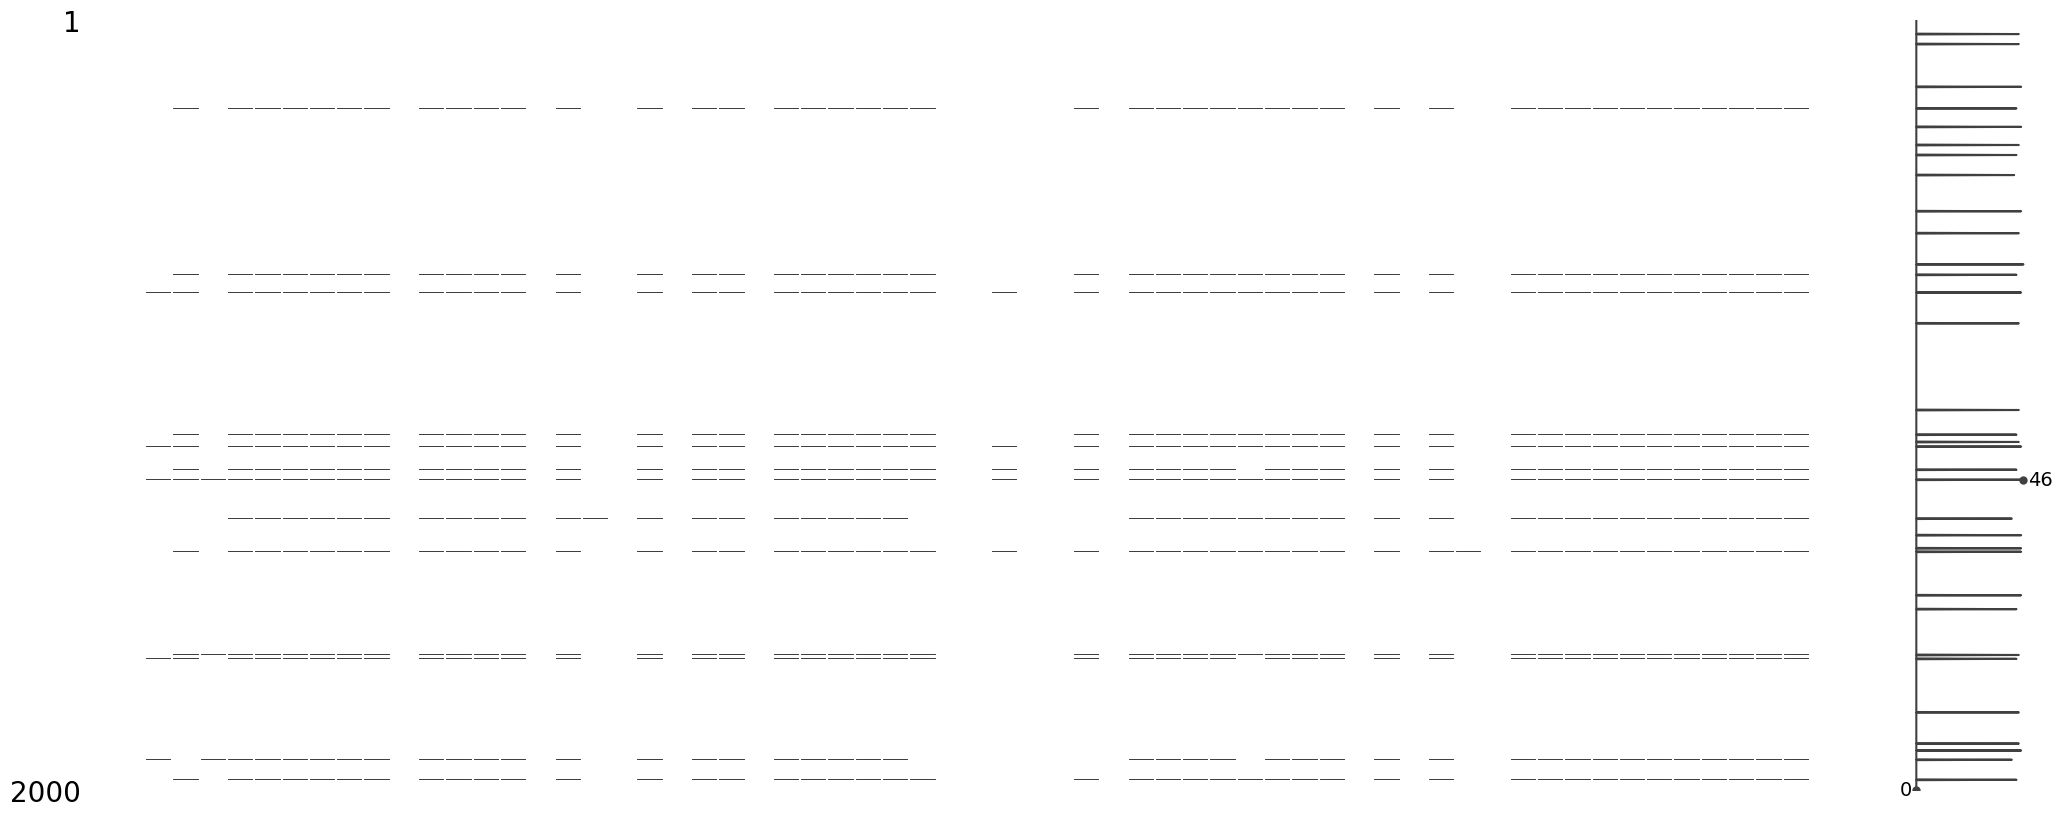

In [52]:
import missingno as msno
import matplotlib.pyplot as plt
print(" Visualizing Missing Values for SCADA:")
msno.matrix(df_energy.sample(min(len(df_energy), 2000)))
plt.show()


In [42]:
len(df_energy)

24228